In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from IPython.core.display import HTML
#css_file = './custom.css'
#HTML(open(css_file, "r").read())

In [2]:
from GPE import GPE_scalar_field
from GPE import ImEx


In [3]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML
font = {'size'   : 15}
matplotlib.rc('font', **font)

fft = np.fft.fft
ifft = np.fft.ifft

def plot_solution(frames, uuhat, x, tt, xi):
    fig = plt.figure(figsize=(12,8))
    axes = fig.add_subplot(211)
    axes2 = fig.add_subplot(212)
    line, = axes.plot(x,frames[0],lw=3)
    line2, = axes2.semilogy(xi,np.abs(np.fft.fft(frames[0])))
    xi_max = np.max(np.abs(xi))
    axes2.semilogy([xi_max/2.,xi_max/2.],[1.e-6,4e8],'--r')
    axes2.semilogy([-xi_max/2.,-xi_max/2.],[1.e-8,4e10],'--r')
    axes.set_xlabel(r'$x$',fontsize=30)
    axes2.set_xlabel(r'$\xi$',fontsize=30)
    plt.tight_layout()
    plt.close()

    def plot_frame(i):
        line.set_data(x,frames[i])
        power_spectrum = np.abs(uuhat[i])**2
        line2.set_data(np.sort(xi),power_spectrum[np.argsort(xi)])
        axes.set_title('t= %.2e' % tt[i])
        axes.set_xlim((-np.pi,np.pi))
        axes.set_ylim((-200,3000))

    anim = matplotlib.animation.FuncAnimation(fig, plot_frame,
                                              frames=len(frames), interval=100,
                                              repeat=False)
    return HTML(anim.to_jshtml())

In [62]:
#1-d Linear example

# Higueras (17)
A    = np.array([[0,0,0],[5/6.,0,0],[11/24,11/24,0]])
Ahat = np.array([[2./11,0,0],[205/462.,2./11,0],[2033/4620,21/110,2/11]])
b = np.array([24/55.,1./5,4./11])
bhat = b

imx = ImEx(3,Ahat,A,bhat,b)



def rhs_f(u,xi,m,n):
    # Evaluate only the non-stiff nonlinear term
    #m = args[1]
    #n = args[2]
    v = (1.0-2.0*np.pi*n*np.pi*n/(m**2))
    
    
    
    return (-1j*m*v*u)

def im_rhs(psi_ft,xi,m,n):
   
    psi_ft = -psi_ft*(xi**2)
    return(1j*0.5*np.fft.ifft(psi_ft)/(m))


def sol_err(psi,t,nx,T,max_err=-1.0):

    sol = np.exp(-1j*(2.0*t*np.pi/T))*np.sin(2.0*np.pi*nx)
    err = np.square(np.abs(sol-psi)).sum()
    err = err/(np.square(np.abs(sol)).sum())
    if(err>max_err):
        max_err = err
    return(max_err)


def solve_1d_example(m,dt):
    L = 2.0
    
    x = np.arange(-m/2,m/2)*(L/m)
    xv = np.array([x,x,x])
    xi = np.fft.fftfreq(m)*m*2*np.pi/L
    pm = 0.1
    pn = 2.0/L
    pnv = np.array([pn,pn,pn])
    nx = np.dot(pn,x)
    print(nx.shape,x.shape)
    
    T = 2.0*np.pi/pm
    
    
    u = np.exp(-1j*0.0)*np.sin(2.0*np.pi*nx)
    
    #chk_err = sol_err(u,0.0,nx,T,-1.0)
    #print("chk err ",chk_err)
   
    print(type(u),u.shape,u.dtype)
    tmax = 2.0

    

    num_plots = 50
    nplt = np.floor((tmax/num_plots)/dt)
    nmax = int(round(tmax/dt))
    print(nplt,nmax)

    frames = [u.copy()]
    tt = [0]
    err_l = []
    mass_l = []
    mass_err_l=[]
    

    
    
    psi = GPE_scalar_field(1,m,im_rhs,rhs_f,imx,u)
    lmbda = (0.5*xi**2)/pm
    max_err = -1.0
    
        
    for n in range(0,nmax):
        
        #print(n)
        for k in range(imx.s):
            psi.update_stage_sum(k,dt)
            psi.do_fft(k,lmbda,dt)
            psi.update_K(k,xi,pm,pn)
        psi.sum_contributions(dt)
        
        
        t = (n+1)*dt
        if np.mod(n,nplt) == 0:
            frames.append(psi.psi)
            tt.append(t)
            err = sol_err(psi.psi,t,nx,T,max_err)
            err_l.append(err)
            
            mass = psi.calc_mass()
            mass_err = (mass-psi.mass_ini)/psi.mass_ini
            
            mass_l.append(mass)
            mass_err_l.append(mass_err)
            


    err = sol_err(psi.psi,t,nx,T,max_err)
    err_l.append(err)
            
    mass = psi.calc_mass()
    mass_err = (mass-psi.mass_ini)/psi.mass_ini
            
    mass_l.append(mass)
    mass_err_l.append(mass_err)
       
    return frames, x,err_l,mass_l,mass_err_l

In [66]:

dt = 0.001


frames, x, err_l, mass_l,mass_err_l = solve_1d_example(128,dt)

(128,) (128,)
chk err  0.0
<class 'numpy.ndarray'> (128,) complex128
40.0 2000
(128,) (128,)


In [3]:
#3-d Linear example

# Higueras (17)
A    = np.array([[0,0,0],[5/6.,0,0],[11/24,11/24,0]])
Ahat = np.array([[2./11,0,0],[205/462.,2./11,0],[2033/4620,21/110,2/11]])
b = np.array([24/55.,1./5,4./11])
bhat = b

imx = ImEx(3,Ahat,A,bhat,b)



def rhs_f(u,xi2,m,n):
    # Evaluate only the non-stiff nonlinear term
    #m = args[1]
    #n = args[2]
    v = (1.0-2.0*np.pi*n*np.pi*n/(m**2))
    
    
    
    return (-1j*m*v*u)

def im_rhs(psi_ft,xi2,m,n):
   
    psi_ft = -psi_ft*(xi2)
    return(1j*0.5*np.fft.ifftn(psi_ft,psi_ft.shape)/(3.0*m))

def sol_err(psi,t,nx,T,max_err=-1.0):

    sol = np.exp(-1j*(2.0*t*np.pi/T))*np.sin(2.0*np.pi*nx)
    #print("sol shape",sol.shape,"psi.shape",psi.shape)
    err = np.square(np.abs(sol-psi).flatten()).sum()
    err = err/(np.square(np.abs(sol).flatten()).sum())
    if(err>max_err):
        max_err = err
    return(max_err)


def solve_3d_example(m,dt):
    L = 2.0
    
    x = np.arange(-m/2,m/2)*(L/m)
    xv,yv,zv = np.meshgrid(x,x,x)
    xi = np.fft.fftfreq(m)*m*2*np.pi/L
    xix,xiy,xiz = np.meshgrid(xi,xi,xi)
    pm = 0.1
    pn = 2.0/L
   
    nx = pn*xv+pn*yv+pn*zv
    
    #nx = np.dot(pnv,xv)
    print("nx shape",nx.shape,"x shape",x.shape)
    
    T = 2.0*np.pi/pm
    
    
    u = np.exp(-1j*0.0)*np.sin(2.0*np.pi*nx)
    
    chk_err = sol_err(u,0.0,nx,T,-1.0)
    print("chk err ",chk_err)
   
    print(type(u),u.shape,u.dtype)
    tmax = 2.0

    

    num_plots = 50
    nplt = np.floor((tmax/num_plots)/dt)
    nmax = int(round(tmax/dt))
    #print(nplt,"nmax",nmax)

    frames = [u.copy()]
    tt = [0]
    err_l = []
    mass_l = []
    mass_err_l=[]
    

    
    
    psi = GPE_scalar_field(3,m,im_rhs,rhs_f,imx,u)
    xi2 = (xix*xix+xiy*xiy+xiz*xiz)
    lmbda = (0.5*xi2)/(3.0*pm)
    
    max_err = -1.0
    
        
    for n in range(0,nmax):
        
        #print(n)
        for k in range(imx.s):
            psi.update_stage_sum(k,dt)
            psi.do_fft(k,lmbda,dt)
            psi.update_K(k,xi2,pm,pn)
        psi.sum_contributions(dt)
        
        
        t = (n+1)*dt
        if np.mod(n,nplt) == 0:
            frames.append(psi.psi)
            tt.append(t)
            err = sol_err(psi.psi,t,nx,T,max_err)
            err_l.append(err)
            
            mass = psi.calc_mass()
            mass_err = (mass-psi.mass_ini)/psi.mass_ini
            
            mass_l.append(mass)
            mass_err_l.append(mass_err)
            


    err = sol_err(psi.psi,t,nx,T,max_err)
    err_l.append(err)
            
    mass = psi.calc_mass()
    mass_err = (mass-psi.mass_ini)/psi.mass_ini
            
    mass_l.append(mass)
    mass_err_l.append(mass_err)
       
    return frames, x,err_l,mass_l,mass_err_l

In [8]:

dt = 0.01


frames, x, err_l, mass_l,mass_err_l = solve_3d_example(64,dt)

nx shape (64, 64, 64) x shape (64,)
chk err  0.0
<class 'numpy.ndarray'> (64, 64, 64) complex128
class shapes (64, 64, 64) (3, 64, 64, 64)
(64, 64, 64) (64, 64, 64)


In [8]:
err_l

[4.53244212345019e-16, 8.729216573338672e-15]

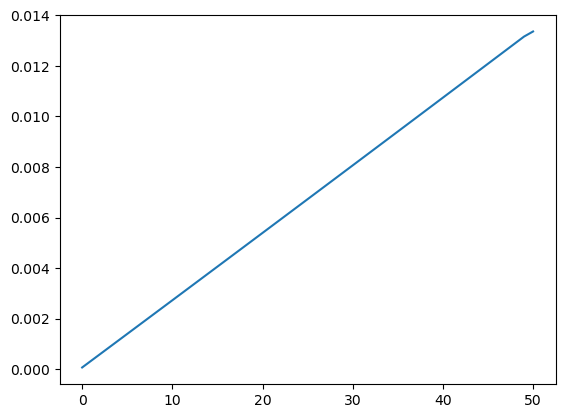

In [10]:
plt.plot(mass_err_l)

In [33]:
f = np.fft.fftn(u,u.shape)

In [35]:
uf = np.fft.ifftn(f,f.shape)

In [39]:
r=u-uf


In [40]:
rr = np.abs(r).flatten()

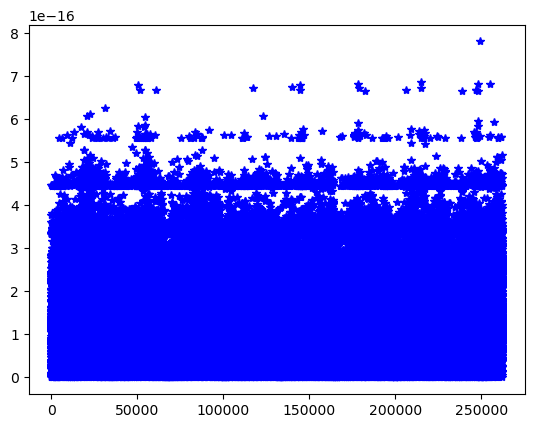

In [41]:
plt.plot(rr,"b*")